# Análisis de Series Temporales - Trabajo Práctico 2

Integrantes:
* Bermejo, Joaquín
* Scarafía, Franco
* Seward, Gerard

## 1. Importación de librerías

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from neuralprophet import NeuralProphet
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

from scipy import stats
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## 2. Carga de datasets

In [3]:
df = pd.read_csv('input/viajes_bici.csv')

df_train = df[df['fecha'] < '2024-01-01']
df_test  = df[df['fecha'] >= '2024-01-01']

In [4]:
eco = df[df['destino'] == 'Fac. Ciencias Económicas']
eco = eco.drop(['destino'], axis=1)

med = df[df['destino'] == 'Fac. Medicina']
med = med.drop(['destino'], axis=1)

ing = df[df['destino'] == 'Fac. de Ingeniería']
ing = ing.drop(['destino'], axis=1)

In [5]:
# Esto de momento no se usa

df_wide = eco.merge(med, on='fecha')
df_wide = df_wide.merge(ing, on='fecha')
df_wide = df_wide.rename(columns={"viajes_x": "eco", "viajes_y": "med", "viajes": "ing"})

In [6]:
eco_train = df_train[df_train['destino'] == 'Fac. Ciencias Económicas']
eco_test  = df_test[df_test['destino'] == 'Fac. Ciencias Económicas']

med_train = df_train[df_train['destino'] == 'Fac. Medicina']
med_test  = df_test[df_test['destino'] == 'Fac. Medicina']

ing_train = df_train[df_train['destino'] == 'Fac. de Ingeniería']
ing_test  = df_test[df_test['destino'] == 'Fac. de Ingeniería']

In [7]:
eco_train = eco_train.drop(['destino'], axis=1)
eco_train = eco_train.rename(columns={"fecha": "ds", "viajes": "y"})

eco_test = eco_test.drop(['destino'], axis=1)
eco_test = eco_test.rename(columns={"fecha": "ds", "viajes": "y"})

med_train = med_train.drop(['destino'], axis=1)
med_train = med_train.rename(columns={"fecha": "ds", "viajes": "y"})

med_test = med_test.drop(['destino'], axis=1)
med_test = med_test.rename(columns={"fecha": "ds", "viajes": "y"})

ing_train = ing_train.drop(['destino'], axis=1)
ing_train = ing_train.rename(columns={"fecha": "ds", "viajes": "y"})

ing_test = ing_test.drop(['destino'], axis=1)
ing_test = ing_test.rename(columns={"fecha": "ds", "viajes": "y"})

## 3. Funciones auxiliares

In [39]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE:  {round(mean_squared_error(serie_test, serie_pred),2)}')
    print(f'MAE:  {round(mean_absolute_error(serie_test, serie_pred),2)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(serie_test, serie_pred)),2)}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

## 4. Ajuste de modelos

### 4a. Prophet

In [8]:
# Se inicializa y entrena el modelo
# Se define el intervalo de confianza en 95% (el valor por default es 80%)
prophet_eco = Prophet(interval_width=0.95)
prophet_eco.fit(eco_train)

18:04:03 - cmdstanpy - INFO - Chain [1] start processing
18:04:04 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Se define la cantidad de períodos a predecir. 121 equivale a la base de testeo
future_eco = prophet_eco.make_future_dataframe(periods=121, freq='d')

In [10]:
# Se generan las predicciones
forecast_eco = prophet_eco.predict(future_eco)
forecast_eco[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1211,2024-04-26,78.787700,31.323334,123.419069
1212,2024-04-27,47.422835,-2.535543,93.930664
1213,2024-04-28,48.091931,4.908529,93.098587
1214,2024-04-29,82.328663,36.095677,128.090913
1215,2024-04-30,89.779453,42.390359,135.629583


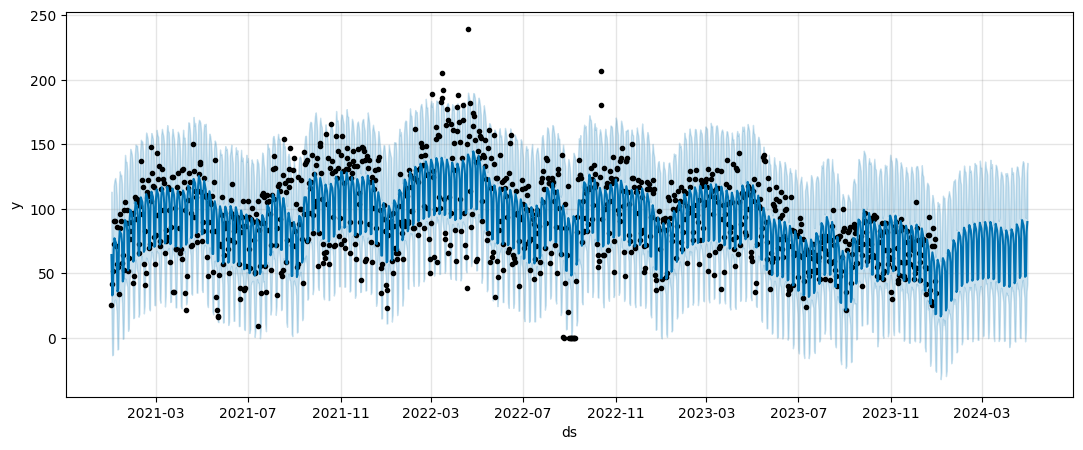

In [11]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = prophet_eco.plot(forecast_eco,ax=ax)
plt.show()

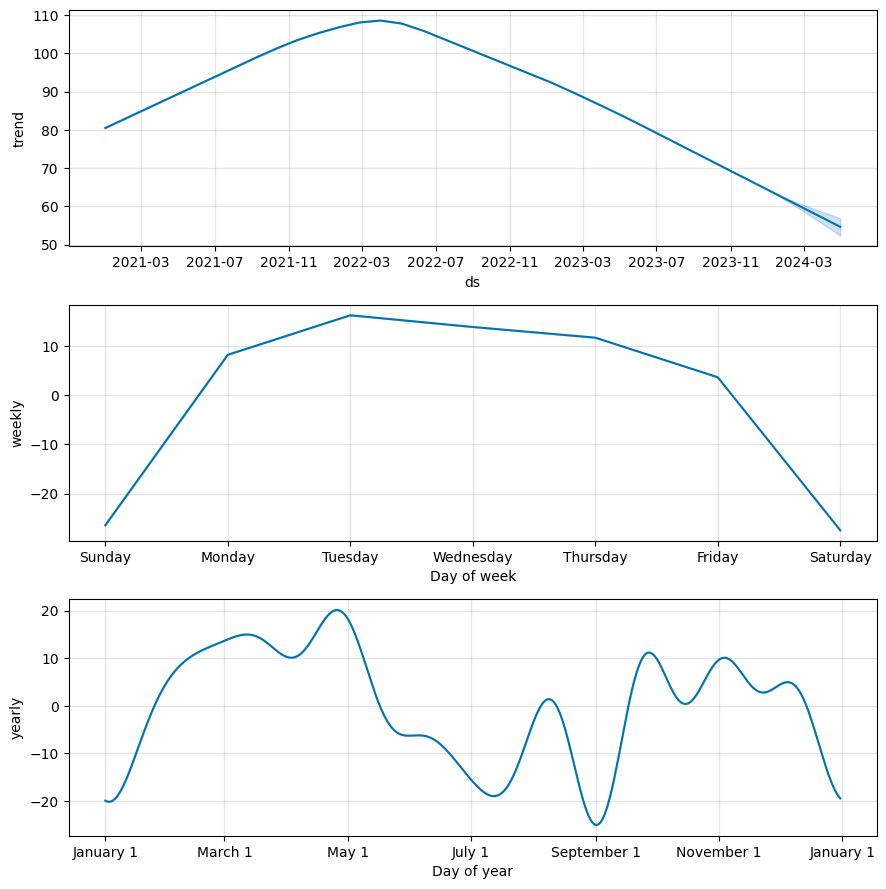

In [12]:
# Se grafican las componenestes de las predicciones
fig2 = prophet_eco.plot_components(forecast_eco)

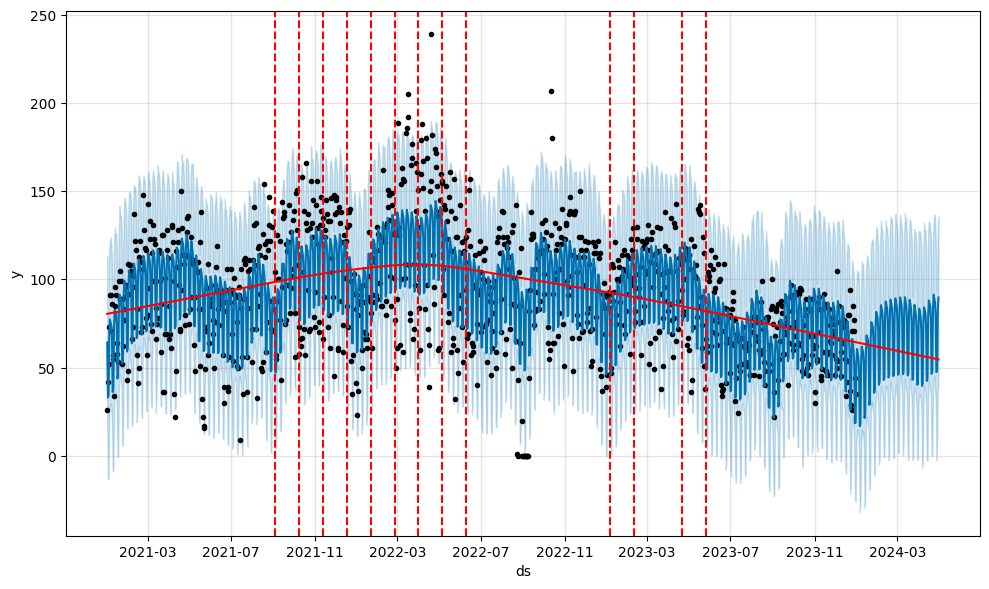

In [13]:
# Se grafican los puntos de cambio
fig = prophet_eco.plot(forecast_eco)
a = add_changepoints_to_plot(fig.gca(), prophet_eco, forecast_eco)

In [14]:
# Se generan las predicciones para la base de testeo
X_eco_forecast = prophet_eco.predict(eco_test)
X_eco_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2024-04-26,78.787700,33.739203,123.162855
117,2024-04-27,47.422835,1.802293,93.144374
118,2024-04-28,48.091931,1.597858,91.584065
119,2024-04-29,82.328663,37.508070,128.651346
120,2024-04-30,89.779453,45.065212,132.997122


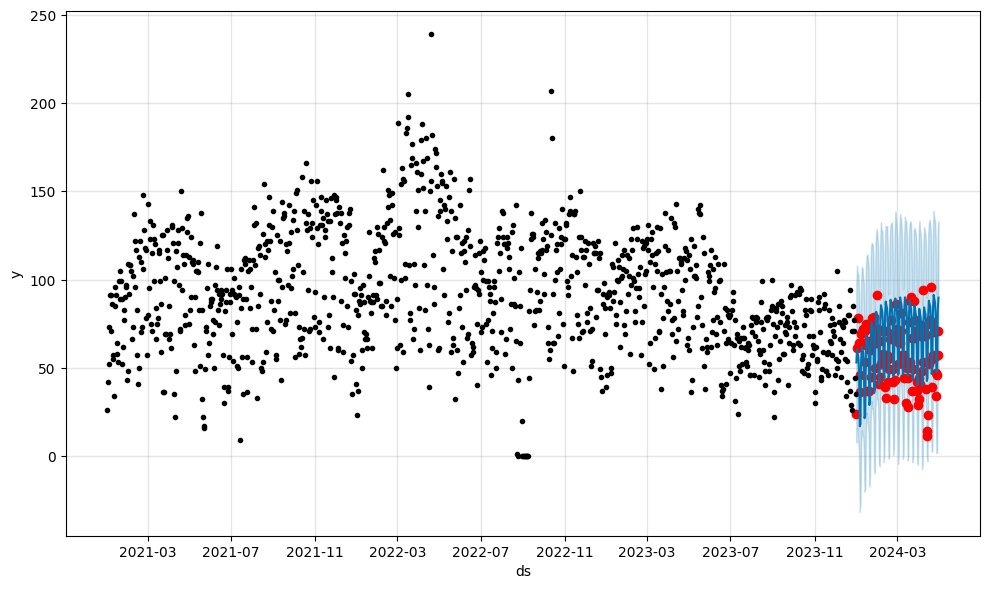

In [15]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
prophet_eco.plot(X_eco_forecast)
plt.scatter(eco_test.ds, eco_test['y'], color='r')

In [16]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(eco_test['y'], X_eco_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(eco_test['y'], X_eco_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test MSE: 481.867
Test MAE: 17.630
Test RMSE: 21.951
Test R2: -0.679


Peor que SARIMA. No le gana al naive estacional.

Como algo positivo podríamos decir que sirve para estudiar mejor el comportamiento de la serie (descriptivo, no inferencial) porque la desglosa en sus múltiples estacionalidades: semanal y anual.

Por ejemplo: se ve cómo los días de mayor actividad son los días de semana dentro del ciclo lectivo (decae sábados y domingos pero también en enero y julio).

In [17]:
# Habilitar la estacionalidad semanal, diaria y anual
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(eco_train)

18:04:39 - cmdstanpy - INFO - Chain [1] start processing
18:04:39 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Se define la cantidad de períodos a predecir. 121 equivale a la base de testeo
future = m.make_future_dataframe(periods=121, freq='d')

In [19]:
# Se generan las predicciones
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1211,2024-04-26,78.787700,33.546115,124.058708
1212,2024-04-27,47.422835,2.200638,92.570404
1213,2024-04-28,48.091931,4.629074,93.848364
1214,2024-04-29,82.328663,40.392992,126.437875
1215,2024-04-30,89.779453,43.122973,136.435916


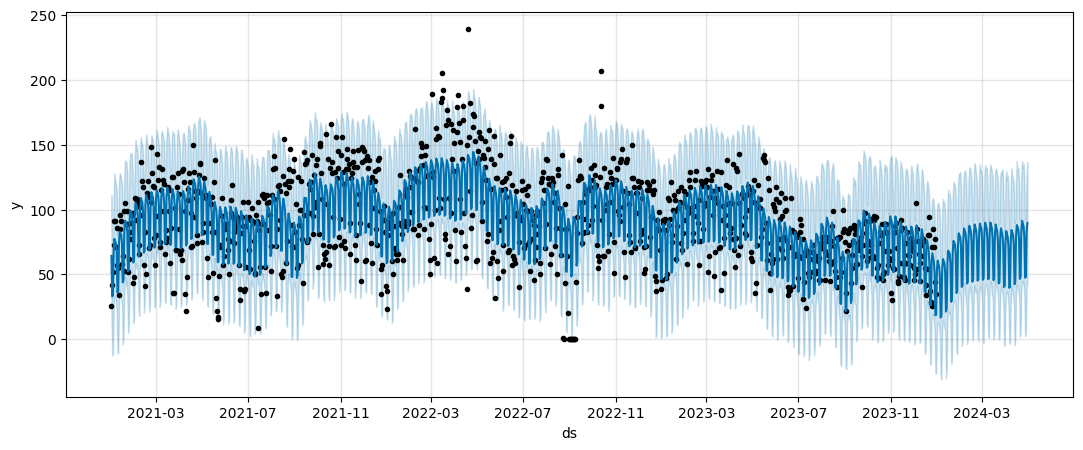

In [20]:
# Se grafican las predicciones (línea) y la base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = m.plot(forecast,ax=ax)
plt.show()

In [21]:
# Se generan las predicciones para la base de testeo
X_eco_forecast = m.predict(eco_test)
X_eco_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2024-04-26,78.787700,31.761325,121.891622
117,2024-04-27,47.422835,4.562706,90.981459
118,2024-04-28,48.091931,2.089061,96.691981
119,2024-04-29,82.328663,34.403539,127.039569
120,2024-04-30,89.779453,44.828157,135.709363


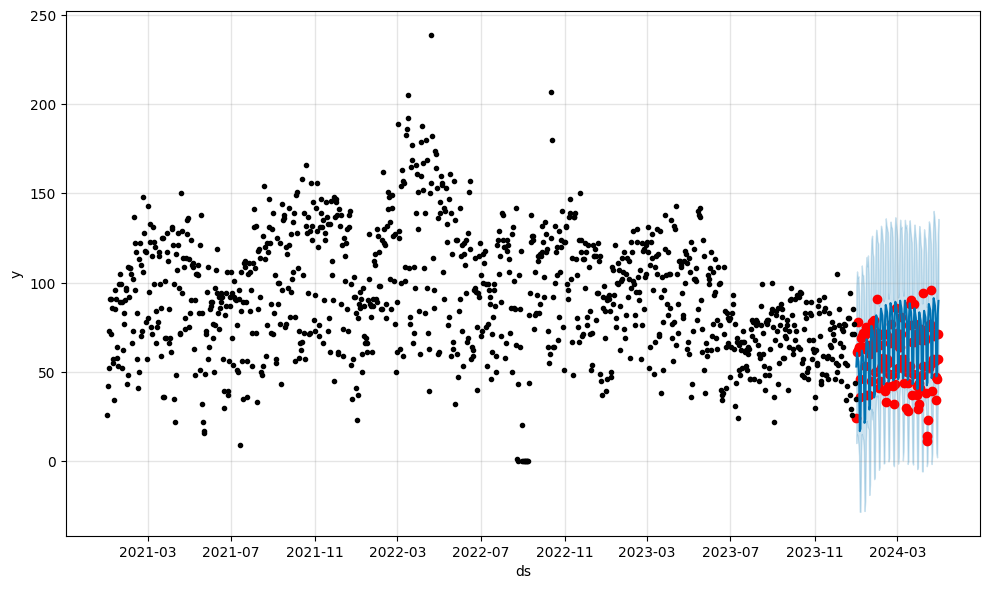

In [22]:
# Se grafican la base de entrenamiento (punteado negro), la de testeo (punteado rojo) y las predicciones (azul)
m.plot(X_eco_forecast)
plt.scatter(eco_test.ds, eco_test['y'], color='r')

In [23]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(eco_test['y'], X_eco_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(eco_test['y'], X_eco_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test MSE: 481.867
Test MAE: 17.630
Test RMSE: 21.951
Test R2: -0.679


Resultados iguales al anterior.

In [24]:
# Dias feriados
dias_feriados = pd.DataFrame({
  'holiday': 'Mantenimiento',
  'ds': pd.to_datetime(['2022-04-19', '2022-10-12', '2022-10-13'])
})

In [25]:
m = Prophet(interval_width=0.95,holidays=dias_feriados)
m.fit(eco_train)

18:04:57 - cmdstanpy - INFO - Chain [1] start processing
18:04:57 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# Se generan las predicciones para la base de testeo
X_eco_forecast = m.predict(eco_test)
X_eco_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2024-04-26,78.643612,35.455212,124.556708
117,2024-04-27,47.416538,3.179992,94.277506
118,2024-04-28,48.226433,1.837689,92.429367
119,2024-04-29,82.606039,33.842643,127.856447
120,2024-04-30,89.624657,45.000160,137.651892


In [27]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(eco_test['y'], X_eco_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(eco_test['y'], X_eco_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(eco_test['y'], X_eco_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test MSE: 481.746
Test MAE: 17.594
Test RMSE: 21.949
Test R2: -0.679


La mejora es insignificante.

Probamos ahora para las otras dos series.

In [28]:
# Se define el modelo
prophet_med = Prophet(interval_width=0.95)
prophet_med.fit(med_train)

# Se define la cantidad de períodos a predecir. 121 equivale a la base de testeo
future_med = prophet_med.make_future_dataframe(periods=121, freq='d')

# Se generan las predicciones
forecast_med = prophet_med.predict(future_med)

# Se generan las predicciones para la base de testeo
X_med_forecast = prophet_med.predict(med_test)

18:05:06 - cmdstanpy - INFO - Chain [1] start processing
18:05:06 - cmdstanpy - INFO - Chain [1] done processing


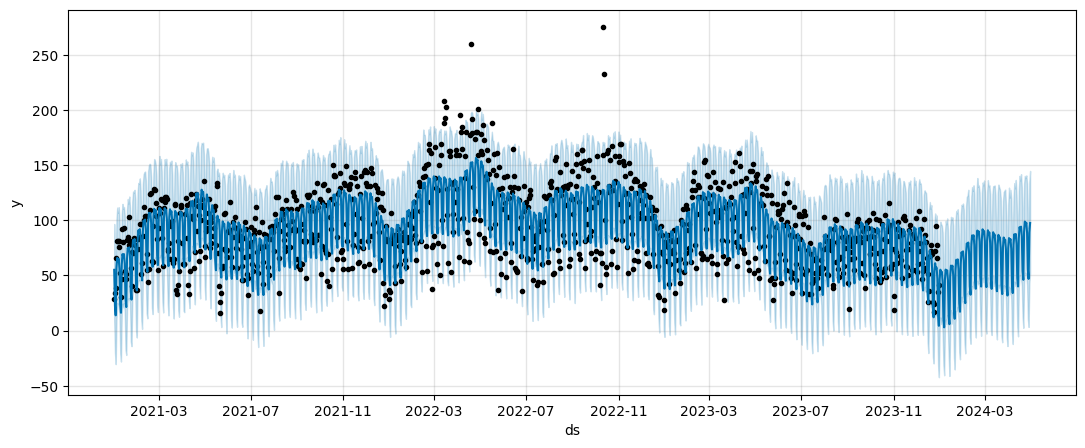

In [29]:
# Predicciones (línea) y base de entranamiento (puntos)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(13)
fig = prophet_med.plot(forecast_med,ax=ax)
plt.show()

In [30]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(med_test['y'], X_med_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(med_test['y'], X_med_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(med_test['y'], X_med_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(med_test['y'], X_med_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test MSE: 513.349
Test MAE: 18.772
Test RMSE: 22.657
Test R2: -0.014


Peor que el SARIMA.

In [31]:
# Se define el modelo
prophet_ing = Prophet(interval_width=0.95)
prophet_ing.fit(ing_train)

# Se define la cantidad de períodos a predecir. 121 equivale a la base de testeo
future_ing = prophet_ing.make_future_dataframe(periods=121, freq='d')

# Se generan las predicciones
forecast_ing = prophet_ing.predict(future_ing)

# Se generan las predicciones para la base de testeo
X_ing_forecast = prophet_ing.predict(ing_test)

18:05:16 - cmdstanpy - INFO - Chain [1] start processing
18:05:16 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# Cálculo de las medidas de precisión
mse = mean_squared_error(ing_test['y'], X_ing_forecast['yhat'])
print('Test MSE: %.3f' % mse)
mae = mean_absolute_error(ing_test['y'], X_ing_forecast['yhat'])
print('Test MAE: %.3f' % mae)
rmse = sqrt(mean_squared_error(ing_test['y'], X_ing_forecast['yhat']))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(ing_test['y'], X_ing_forecast['yhat'])
print('Test R2: %.3f' % r2)

Test MSE: 425.686
Test MAE: 17.292
Test RMSE: 20.632
Test R2: -0.212


Tampoco le gana a SARIMA.

### 4b. AutoGluon

In [33]:
df = df[(df['destino'] == 'Fac. Ciencias Económicas') | (df['destino'] == 'Fac. Medicina') | (df['destino'] == 'Fac. de Ingeniería')]

df       = TimeSeriesDataFrame(df,       id_column='destino', timestamp_column='fecha')
df_train = TimeSeriesDataFrame(df_train, id_column='destino', timestamp_column='fecha')
df_test  = TimeSeriesDataFrame(df_test,  id_column='destino', timestamp_column='fecha')

In [34]:
predictor = TimeSeriesPredictor(
    prediction_length=121,
    path="autoGL_models",
    target="viajes",
    eval_metric="RMSE",
)

predictor.fit(
    df_train,
    presets="best_quality", #"fast_training", "high_quality" , "medium_quality" "best_quality"
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\tp-series-temporales\autoGL_models'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          4
GPU Count:          0
Memory Avail:       0.97 GB / 5.88 GB (16.4%)
Disk Space Avail:   27.52 GB / 237.23 GB (11.6%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 121,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'viajes',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 6570 rows, 6 time series. Median time series 

In [35]:
predictions = predictor.predict(df_train)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [36]:
predictor.leaderboard(df)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,AutoETS,-17.504593,-21.834758,1.349172,1.171695,1.660381,6
1,PatchTST,-18.403014,-21.441322,0.108213,0.072008,65.837512,9
2,DynamicOptimizedTheta,-18.487863,-21.733177,61.646992,1.873366,45.959710,5
3,WeightedEnsemble,-20.310189,-17.475196,7.813771,8.169271,3.425969,11
4,TemporalFusionTransformer,-20.917616,-25.572148,0.128944,0.066636,66.916259,7
5,RecursiveTabular,-21.444912,-27.344996,6.340868,5.823005,15.029489,2
6,DeepAR,-22.760872,-19.740292,1.467314,2.346266,66.303612,8
7,TiDE,-23.221853,-23.920101,0.130383,0.113147,68.749498,10
8,SeasonalNaive,-23.797527,-27.101542,0.070637,0.346838,10.250710,1
9,NPTS,-35.838036,-27.552136,15.303378,4.286809,4.512666,4


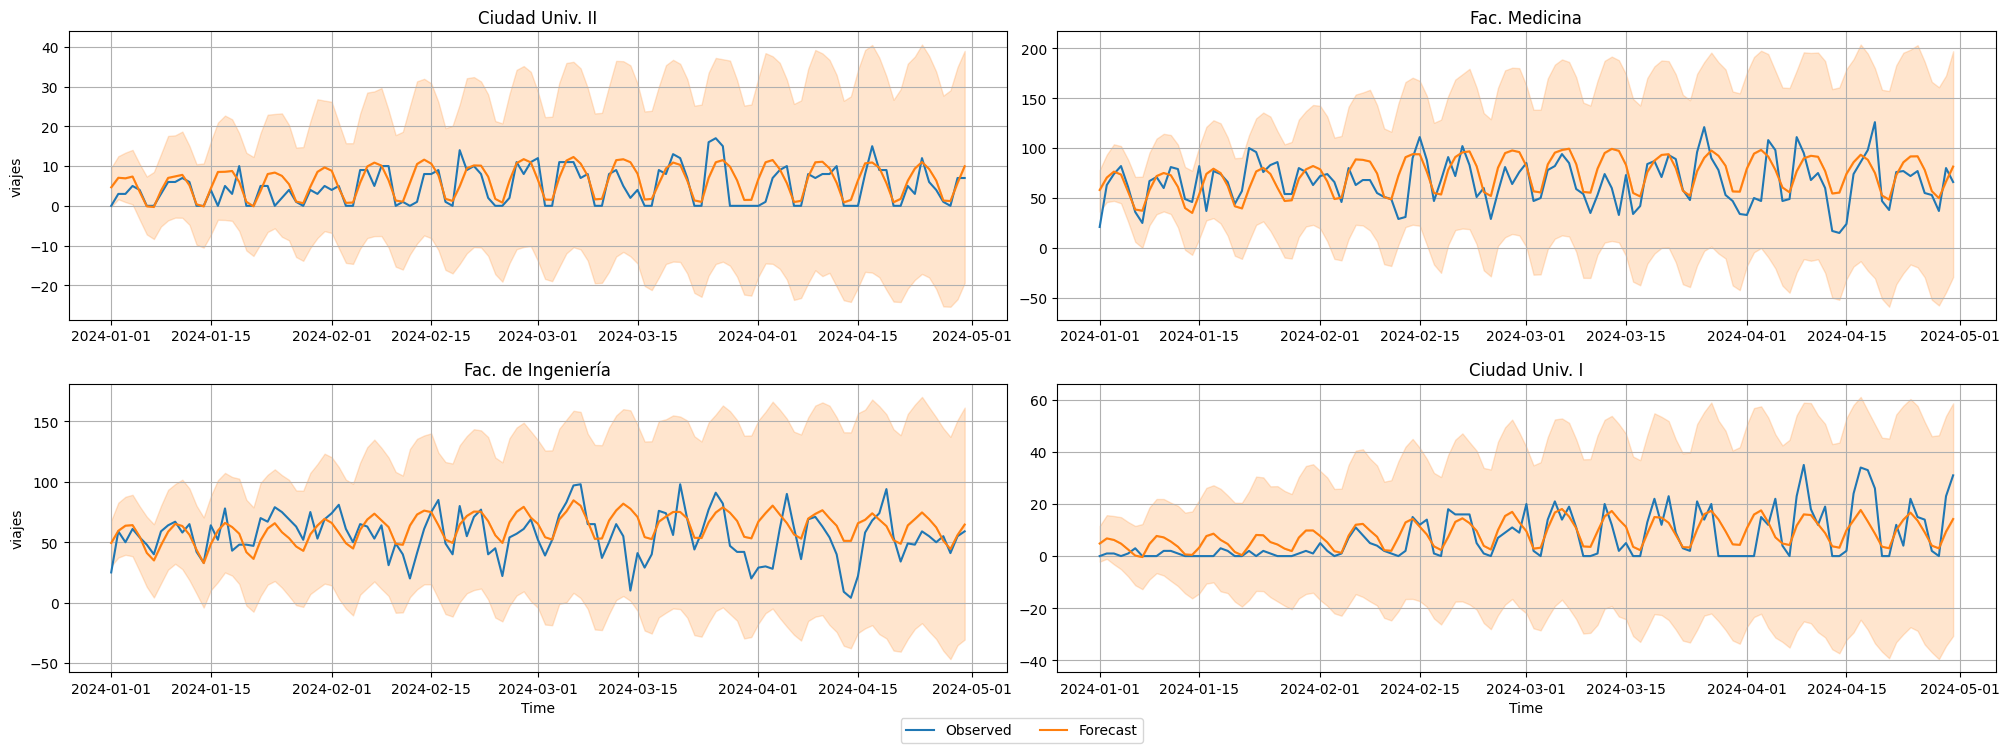

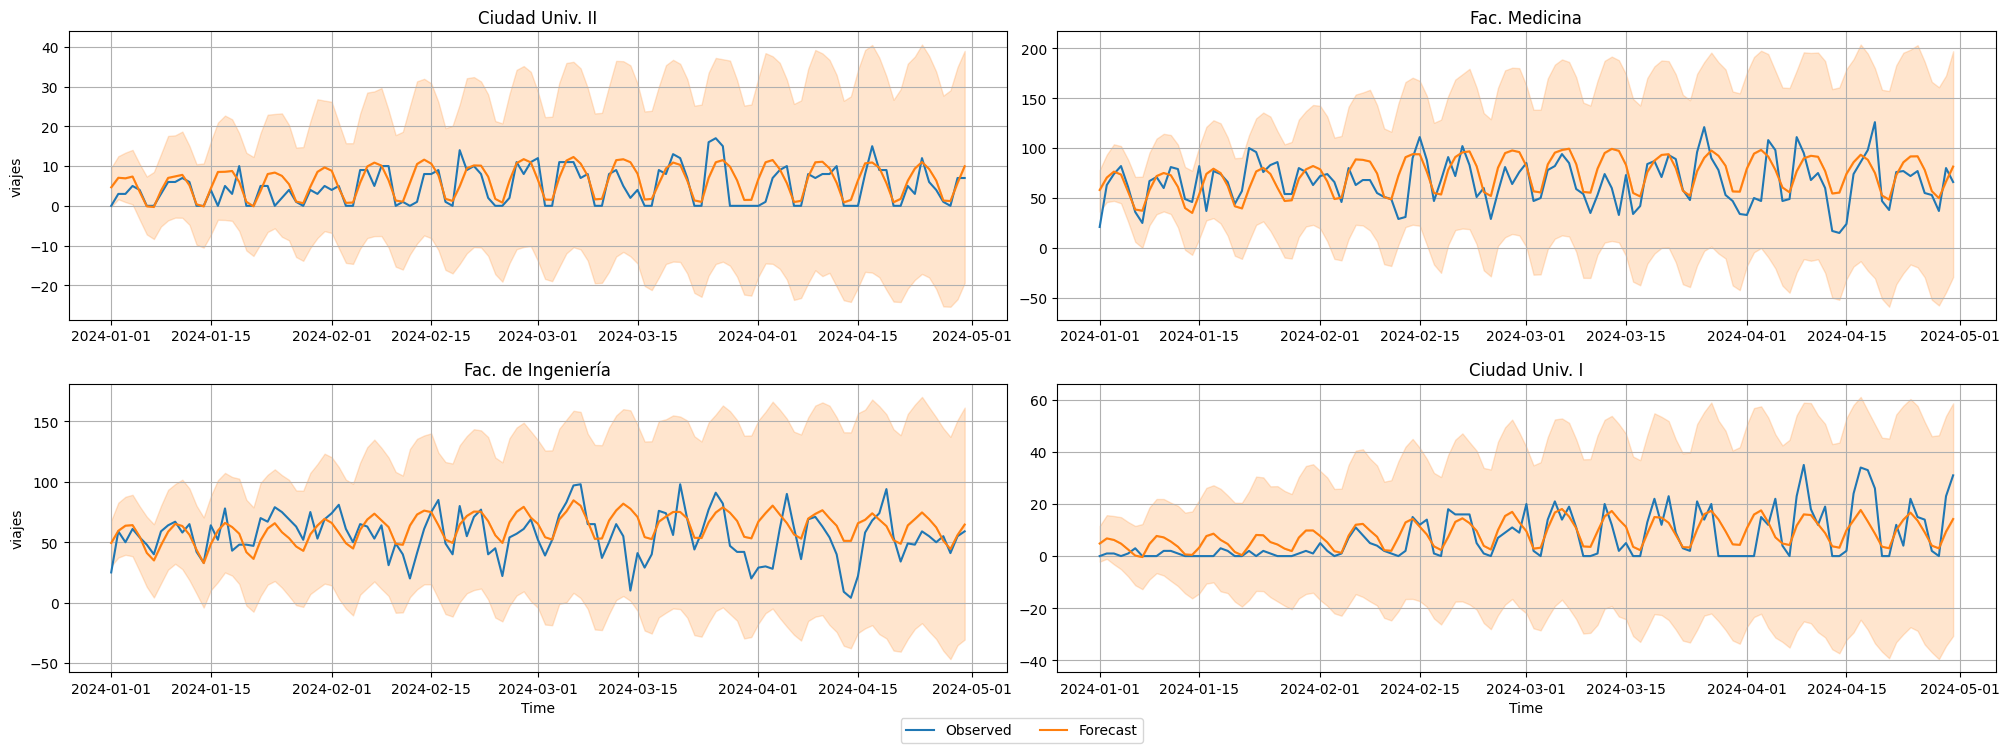

In [37]:
predictor.plot(df_test, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [40]:
# Metricas individuales por serie

for model in predictor.model_names():
    predictions = predictor.predict(df_train, model = model)
    df_test['pred'] = predictions['mean']
    print(24*"#")
    print(model)
    print(24*"#")
    print("Fac. Cs Economicas")
    evaluar_metricas(df_test.iloc[::3, :]['viajes'], df_test.iloc[::3, :]['pred'])   # Fac. Cs Economicas
    print(12*"-")
    print("Fac. Medicina")
    evaluar_metricas(df_test.iloc[1::3, :]['viajes'], df_test.iloc[1::3, :]['pred']) # Fac. Medicina
    print(12*"-")
    print("Fac. de Ingenieria")
    evaluar_metricas(df_test.iloc[2::3, :]['viajes'], df_test.iloc[2::3, :]['pred']) # Fac. de Ingenieria
    print("\n")

########################
SeasonalNaive
########################
Fac. Cs Economicas
MSE:  486.12
MAE:  16.68
RMSE: 22.05
MAPE: 0.3343
------------
Fac. Medicina
MSE:  467.49
MAE:  13.64
RMSE: 21.62
MAPE: inf
------------
Fac. de Ingenieria
MSE:  227.68
MAE:  9.39
RMSE: 15.09
MAPE: inf


########################
RecursiveTabular
########################
Fac. Cs Economicas
MSE:  423.58
MAE:  16.12
RMSE: 20.58
MAPE: 0.347
------------
Fac. Medicina
MSE:  333.58
MAE:  12.58
RMSE: 18.26
MAPE: inf
------------
Fac. de Ingenieria
MSE:  195.77
MAE:  9.45
RMSE: 13.99
MAPE: inf


########################
DirectTabular
########################
Fac. Cs Economicas
MSE:  1867.71
MAE:  34.3
RMSE: 43.22
MAPE: 0.7504
------------
Fac. Medicina
MSE:  795.85
MAE:  18.68
RMSE: 28.21
MAPE: inf
------------
Fac. de Ingenieria
MSE:  1356.95
MAE:  22.74
RMSE: 36.84
MAPE: inf


########################
NPTS
########################
Fac. Cs Economicas
MSE:  1091.59
MAE:  28.21
RMSE: 33.04
MAPE: 0.6459
----------